In [1]:
import os
import sys
import re

import scipy
import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO

from helperFxns import lett2num, alg2bin, filterAln, simMat, num2lett


In [2]:
# if it is one of A.fasta, B.fasta, C.fasta, D.fasta, then it is the raw MSA file
# use regular expression to match the file name

files = [f for f in os.listdir() if re.match(r'[A-D]\.fasta', f)]

for file in files:
    # read the file with the Bio.SeqIO module
    encoding_file = file.split('.')[0] + '_one-hot.npy'
    header_file = file.split('.')[0] + '_header.txt'
    filter_header_file = file.split('.')[0] + '_filter_header.txt'
    headers = []
    seqs = []
    for seq_record in SeqIO.parse(file, "fasta"):
        header = '>' + str(seq_record.description)
        headers.append(header)
        seq = str(seq_record.seq)
        seqs.append(seq)


    with open(header_file, 'w') as f:
        for header in headers:
            f.write(header)
            f.write('\n')

    # one-hot encode the sequences
    num = lett2num(seqs, code='ACDEFGHIKLMNPQRSTVWY-')
    # print(num)
    bin = alg2bin(num, N_aa=21)
    # print(bin)
    # sys.exit()

    # filter out highly gapped positions and sequences according to the cutoff
    hdFilter, seqFilter = filterAln(headers, num)
    # print(seqFilter)
    # print(seqFilter.shape)
    print("After filtering, the number of filtered sequences for file {}: {}".format(file, seqFilter.shape[0]))
    print("After filtering, the number of filtered positions for file {}: {}".format(file, seqFilter.shape[1]))
    # print(len(hdFilter))

    with open(filter_header_file, 'w') as f:
        for header in hdFilter:
            f.write(header)
            f.write('\n')
    # print(seqFilter)
    filtered_seq_list = num2lett(seqFilter, code='ACDEFGHIKLMNPQRSTVWY-')
    # print(hdFilter)
    # print(filtered_seq_list)
    filtered_fasta_file = file.split('.')[0] + '_filtered.fasta'


    if len(hdFilter) == len(filtered_seq_list):
        with open(filtered_fasta_file, 'w') as f:
            for i in range(len(hdFilter)):
                f.write(hdFilter[i])
                f.write('\n')
                f.write(filtered_seq_list[i])
                f.write('\n')
    else:
        raise ValueError("The number of headers and sequences do not match, please check the filtering process")

    # filter_bin = alg2bin(seqFilter, N_aa=21)

    # # compute a sequence identity matrix
    # sim = simMat(filter_bin, seqFilter.shape[1])

    # # sim is a symmetric matrix, get the values above the diagonal
    # sim_diag = sim[np.triu_indices(sim.shape[0], k=1)]
    # # convert to a shape (n,) array
    # sim_diag = np.array(sim_diag).reshape(-1)
    
    # # calculate the mean of the sequence identities
    # mean_sim = np.mean(sim_diag)
    # print("The mean sequence identity for file {}: {}".format(file, round(mean_sim, 3)))

    # # plot the histogram of sequence identities for each MSA
    # plt.figure()
    # plt.hist(sim_diag, bins=100)
    # plt.xlabel('Sequence identity')
    # plt.ylabel('Counts')
    # plt.title('Histogram of sequence identities of proteins in MSA_{}'.format(
    #     file.split('.')[0]))
    # # plt.show()
    # plt.savefig(file.split('.')[0] + '_hist.png')


After filtering, the number of filtered sequences for file A.fasta: 3104
After filtering, the number of filtered positions for file A.fasta: 161
After filtering, the number of filtered sequences for file B.fasta: 3040
After filtering, the number of filtered positions for file B.fasta: 264
After filtering, the number of filtered sequences for file C.fasta: 3178
After filtering, the number of filtered positions for file C.fasta: 267
After filtering, the number of filtered sequences for file D.fasta: 3643
After filtering, the number of filtered positions for file D.fasta: 401


In [20]:
import numpy as np

def average_pooling(matrix, stride):
    N = matrix.shape[0]
    n =  N // stride
    result = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            print(np.mean(matrix[i * stride:(i + 1) * stride, j * stride:(j + 1) * stride]))
            result[i, j] = np.mean(matrix[i * stride:(i + 1) * stride, j * stride:(j + 1) * stride])

    return result


def rms_pooling(matrix, stride):
    N = matrix.shape[0]
    n =  N // stride
    result = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            result[i, j] = np.sqrt(np.mean(matrix[i * stride:(i + 1) * stride, j * stride:(j + 1) * stride] ** 2))

    return result


def rooted_square_pooling(matrix, stride):
    N = matrix.shape[0]
    n =  N // stride
    result = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            result[i, j] = np.sqrt(np.sum(matrix[i * stride:(i + 1) * stride, j * stride:(j + 1) * stride] ** 2))

    return result



# test
N = 6
original_matrix = np.random.rand(N, N)
n = 3
compressed_matrix = average_pooling(original_matrix, n)

original_matrix = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14, 15, 16]])
n = 2
compressed_matrix = rms_pooling(original_matrix, n)
print(compressed_matrix)
print(original_matrix.shape)
print(type(original_matrix))
original_matrix = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14, 15, 16]])
n = 2
compressed_matrix = rooted_square_pooling(original_matrix, n)
print(compressed_matrix)



0.6249374779732096
0.29519428875647474
0.5727001119203344
0.38624548302353306
[[ 4.0620192   5.87367006]
 [11.68332145 13.65650028]]
(4, 4)
<class 'numpy.ndarray'>
[[ 8.1240384  11.74734012]
 [23.36664289 27.31300057]]


['A_filtered.fasta', 'B_filtered.fasta', 'C_filtered.fasta', 'D_filtered.fasta']
(1, 3381)
(3104, 3381)
(3104, 3381)
(3381, 3104)
(3381, 3381)
The number of sequences in the MSA is: 3104
(3381, 3381)
<class 'numpy.matrix'>
<class 'numpy.ndarray'>
(161, 161)
[[0.30215439 0.09495032 0.04972818 ... 0.05442054 0.08693697 0.08030645]
 [0.09495032 0.36642765 0.02179484 ... 0.04675947 0.05348644 0.06462299]
 [0.04972818 0.02179484 0.33698778 ... 0.10230565 0.06937265 0.07257818]
 ...
 [0.05442054 0.04675947 0.10230565 ... 0.34971183 0.13188969 0.10731717]
 [0.08693697 0.05348644 0.06937265 ... 0.13188969 0.42121593 0.16527683]
 [0.08030645 0.06462299 0.07257818 ... 0.10731717 0.16527683 0.32436309]]
(1, 5544)
(3040, 5544)
(3040, 5544)
(5544, 3040)
(5544, 5544)
The number of sequences in the MSA is: 3040
(5544, 5544)
<class 'numpy.matrix'>
<class 'numpy.ndarray'>
(264, 264)
[[0.39843114 0.08669463 0.11480045 ... 0.00165896 0.03617049 0.05251778]
 [0.08669463 0.34204553 0.22939011 ... 0.0020605

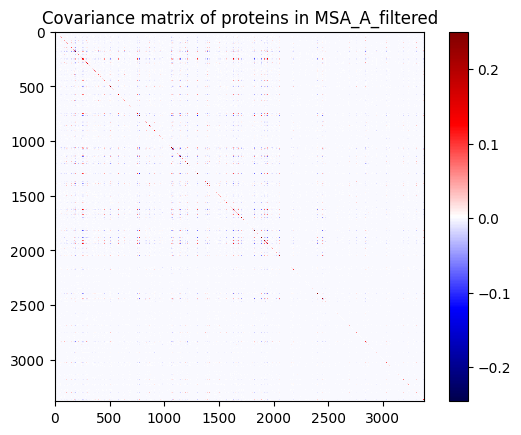

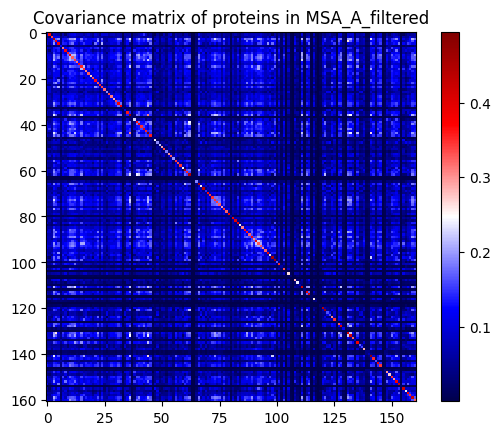

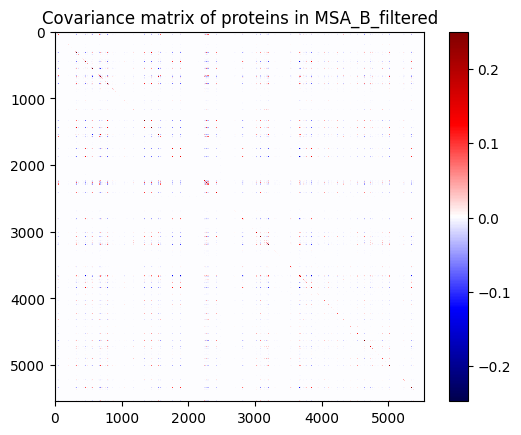

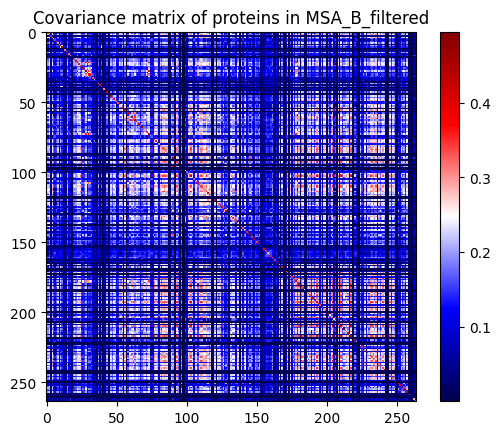

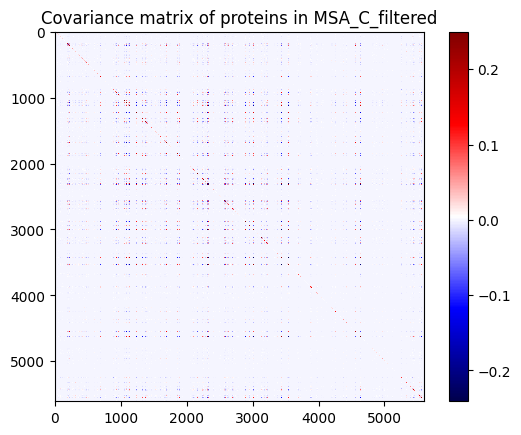

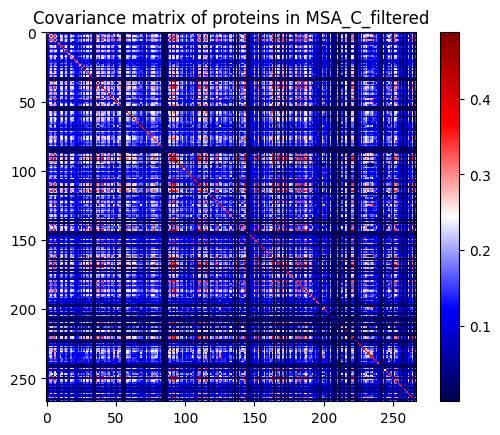

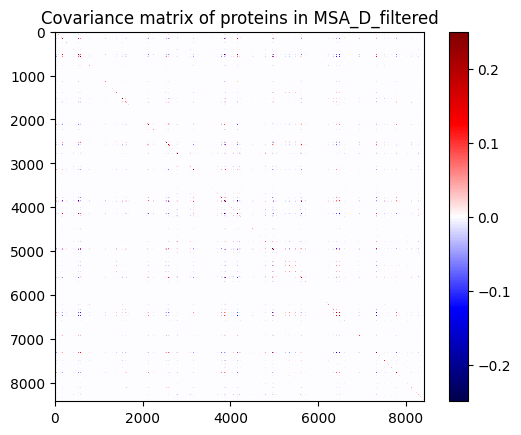

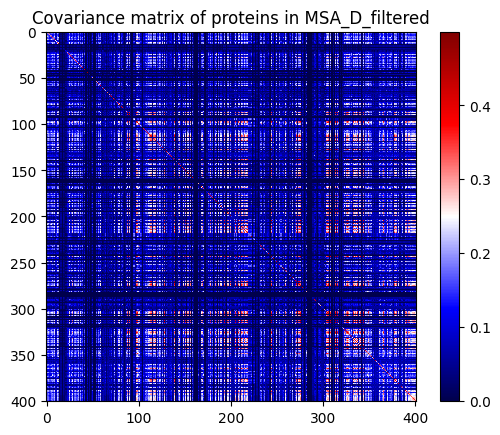

In [28]:
filtered_files = [f for f in os.listdir() if re.match(r'[A-D]_filtered\.fasta', f)]
print(filtered_files)


for file in filtered_files:
    # read the file with the Bio.SeqIO module
    headers = []
    seqs = []
    for seq_record in SeqIO.parse(file, "fasta"):
        header = '>' + str(seq_record.description)
        headers.append(header)
        seq = str(seq_record.seq)
        seqs.append(seq)
    
    # one-hot encode the sequences
    num = lett2num(seqs, code='ACDEFGHIKLMNPQRSTVWY-')
    # print(num)
    bin = alg2bin(num, N_aa=21)
    # print(bin)
    # what data type is bin?
    # print(type(bin))
    # mulitply the bin by its transpose



    X_mean = np.mean(bin, axis=0)
    # print(X_mean)
    print(X_mean.shape)
    # for each position, subtract the mean
    # print(bin)
    print(bin.shape)



    bin_transpose = np.transpose(bin)
    # multiply the bin and bin_transpose
    print(bin.shape)
    print(bin_transpose.shape)
    print(np.dot(np.transpose(X_mean), X_mean).shape)
    num_seq = bin.shape[0]
    print("The number of sequences in the MSA is: {}".format(num_seq))
    cov_mat = np.dot(bin_transpose, bin)/num_seq
    cov_mat = cov_mat - np.dot(np.transpose(X_mean), X_mean)
    print(cov_mat.shape)
    print(type(cov_mat))
    # print(cov_mat)
    cov_mat= np.array(cov_mat)
    print(type(cov_mat))

    # plot the covariance matrix
    plt.figure()
    plt.imshow(cov_mat, cmap='seismic', interpolation='nearest')
    plt.colorbar()
    plt.title('Covariance matrix of proteins in MSA_{}'.format(
        file.split('.')[0]))
    plt.savefig(file.split('.')[0] + '_cov.png')

    # sys.exit()


    cov_mat_compressed = rooted_square_pooling(cov_mat, 21)
    print(cov_mat_compressed.shape)
    print(cov_mat_compressed)
    # plot the covariance matrix
    plt.figure()
    plt.imshow(cov_mat_compressed, cmap='seismic', interpolation='nearest')
    plt.colorbar()
    plt.title('Covariance matrix of proteins in MSA_{}'.format(
        file.split('.')[0]))
    plt.savefig(file.split('.')[0] + '_cov.png')
    # sys.exit()
    # plt.show()
    # break


['A_filtered.fasta', 'B_filtered.fasta', 'C_filtered.fasta', 'D_filtered.fasta']
Tax ID 1513468_0 is duplicated
Tax ID 2589817_0 is duplicated
Tax ID 2027290_0 is duplicated
Tax ID 565_0 is duplicated
Tax ID 2041079_0 is duplicated
Tax ID 1736699_0 is duplicated
Tax ID 208224_0 is duplicated
Tax ID 2027290_0 is duplicated
Tax ID 381306_0 is duplicated
Tax ID 171383_0 is duplicated
Tax ID 1871111_0 is duplicated
Tax ID 2136183_0 is duplicated
Tax ID 1443941_0 is duplicated
Tax ID 2004646_0 is duplicated
Tax ID 300_0 is duplicated
Tax ID 2479853_0 is duplicated
Tax ID 1736226_0 is duplicated
Tax ID 2060418_0 is duplicated
Tax ID 2293832_0 is duplicated
Tax ID 1869229_0 is duplicated
Tax ID 216595_0 is duplicated
Tax ID 2054919_0 is duplicated
Tax ID 33069_8 is duplicated
Tax ID 255519_0 is duplicated
Tax ID 565_0 is duplicated
Tax ID 1985876_0 is duplicated
Tax ID 1736699_0 is duplicated
Tax ID 83655_0 is duplicated
Tax ID 1812935_0 is duplicated
Tax ID 2041079_0 is duplicated
Tax ID 208